In [54]:
%matplotlib inline
import cv2
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import numpy as np
import seaborn as sns
import scipy
from tqdm import tqdm

import preprocess as pp

## TODO:

1. outlier detection -- z score?
2. better signal extraction
3. superpixel segmentation

In [2]:
from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('font',**{'family':'serif','serif':['Times New Roman']})
# rc('text', usetex=True)

In [3]:
test_video = 'data/marker_raw_480x480_30fps.mp4'
if not os.path.isfile(test_video): raise Exception('invalid video path')

In [4]:
# preprocess
stabilized_array = pp.preprocess(
    test_video,
    output='array',
    smoothing_window=5,
)
print(stabilized_array.shape)

stabilizing output


  0%|          | 0/1415 [00:00<?, ?it/s]

100%|█████████▉| 1414/1415 [00:24<00:00, 58.39it/s]


smoothing output
(1414, 480, 480, 3)


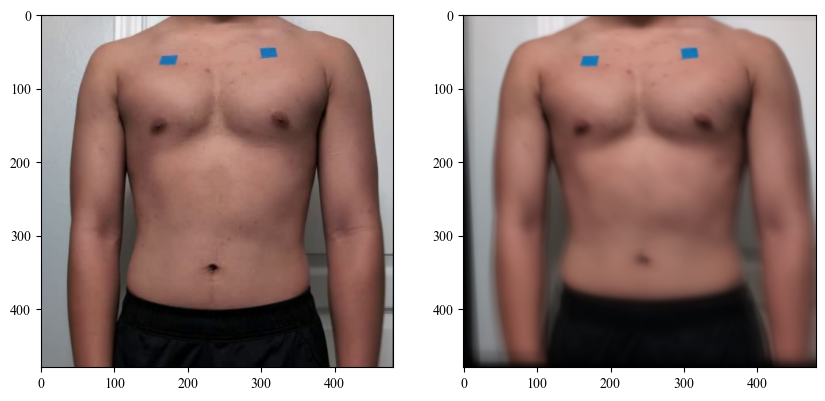

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(cv2.cvtColor(stabilized_array[0], cv2.COLOR_BGR2RGB))
ax[1].imshow(pp.smear(stabilized_array))

In [65]:
lsc_arr = pp.smear(stabilized_array)

In [66]:
lsc = cv2.ximgproc.createSuperpixelLSC(lsc_arr, 
                                       region_size=25,
                                       ratio=0.075)
lsc.iterate(20)
lsc_mask = lsc.getLabels()
num_chunks = lsc.getNumberOfSuperpixels()

361


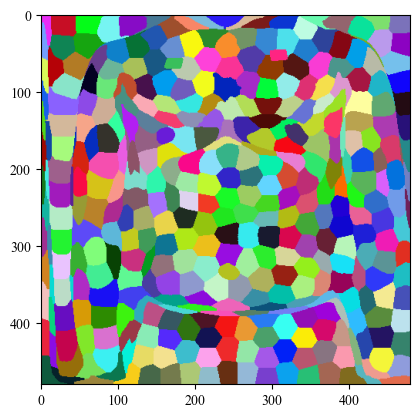

In [74]:
import random
colors = [(random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)) for _ in range(num_chunks)]
lsc_mask_rgb = np.zeros_like(lsc_arr)
for i in range(num_chunks):
    lsc_mask_rgb[lsc_mask == i] = colors[i]

print(num_chunks)
plt.figure()
plt.imshow(lsc_mask_rgb)
plt.show()

In [70]:
def mask_avg_image(mask, image):
    avg_image = np.zeros_like(image)
    for i in range(num_chunks):
        avg_image[mask == i] = np.mean(image[mask == i], axis=0)
    return avg_image

In [170]:
mask_results = mask_avg_image(lsc_mask, stabilized_array[0])
r, g, b = stabilized_array[0][np.newaxis].transpose(3, 0, 1, 2)
blocking_results = np.dstack([pp.resize_func(np.mean, a, 24)[0] for a in (r, g, b)]).astype(np.uint8)
blocking_results = cv2.cvtColor(blocking_results, cv2.COLOR_BGR2RGB)

In [73]:
frames = []
for i in tqdm(stabilized_array):
    frames.append(mask_avg_image(lsc_mask, i))
lsc_array = np.array(frames)

100%|██████████| 1414/1414 [16:40<00:00,  1.41it/s]


In [95]:
pp.ndarray_to_vid(lsc_array, 'data/superpixel_lsc.mp4', 30)

In [94]:
pp.video_playback_fromframes(lsc_array, fps=30)

In [97]:
def mask_chunk_avg_image(mask, image):
    return np.array([np.mean(image[mask == i], axis=0) for i in range(num_chunks)])

In [98]:
lsc_mean_array = np.array([mask_chunk_avg_image(lsc_mask, i) for i in tqdm(stabilized_array)])

100%|██████████| 1414/1414 [04:18<00:00,  5.47it/s]


In [112]:
lsc_mean_array_4d = lsc_mean_array[:, :, np.newaxis, :].reshape(-1, 19, 19, 3).astype(np.uint8)
lsc_mean_array_4d = np.rot90(lsc_mean_array_4d, k=-1, axes=(1, 2))
print(lsc_mean_array_4d.shape)

(1414, 19, 19, 3)


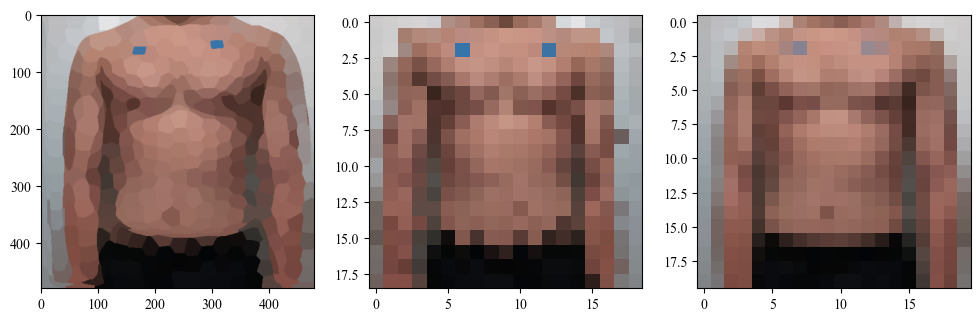

In [172]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow(cv2.cvtColor(mask_results, cv2.COLOR_BGR2RGB))
ax[1].imshow(cv2.cvtColor(lsc_mean_array_4d[0], cv2.COLOR_BGR2RGB))
ax[2].imshow(blocking_results)
plt.savefig('data/superpixel_lsc_results.png', bbox_inches='tight')


In [116]:
pp.ndarray_to_vid(lsc_mean_array_4d, 'data/superpixel_lsc_chunks.mp4', 30)
pp.video_playback_fromframes(lsc_mean_array_4d, fps=30)

In [117]:
np.save('data/superpixel_lsc_chunks.npy', lsc_mean_array_4d)

In [118]:
# test_array = stabilized_array
test_array = lsc_mean_array_4d
cv_channels = {'b': 0, 'g': 1, 'r': 2}
test_array_green = test_array[:, :, :, cv_channels['g']]
test_array_red = test_array[:, :, :, cv_channels['r']]
test_array_blue = test_array[:, :, :, cv_channels['b']]
print(test_array_green.shape)

(1414, 19, 19)


(361, 1414)


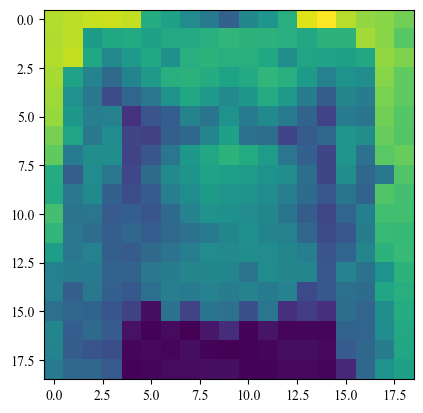

In [120]:
block_size = 1

n_frames = test_array_green.shape[0]
green_signals = pp.resize_func(np.mean, test_array_green, block_size).reshape(n_frames, -1).swapaxes(0, 1)
red_signals = pp.resize_func(np.mean, test_array_red, block_size).reshape(n_frames, -1).swapaxes(0, 1)
blue_signals = pp.resize_func(np.mean, test_array_blue, block_size).reshape(n_frames, -1).swapaxes(0, 1)
print(green_signals.shape)

plt.figure()
plt.imshow(pp.resize_func(np.mean, test_array_green, block_size)[0], cmap='viridis')
plt.show()

In [121]:
def chrom(r, g, b, fps, fft=False):

    rgb_mean = (r + g + b) / 3
    Rn, Gn, Bn = r/rgb_mean, g/rgb_mean, b/rgb_mean

    Xs = 3*Rn - 2*Gn
    Ys = 1.5*Rn + Gn - 1.5*Bn

    low_freq = 40/60
    high_freq = 240/60

    iirb, iira = scipy.signal.butter(3, ((2*low_freq)/fps, (2*high_freq)/fps), 'bandpass')

    Xf = scipy.signal.filtfilt(iirb, iira, Xs)
    Yf = scipy.signal.filtfilt(iirb, iira, Ys)

    alpha = np.std(Xf) / np.std(Yf)
    S = Xf - alpha*Yf
    
    if fft:
        S_fft = np.abs(np.fft.rfft(S))
        return S_fft
    else:
        return S

In [122]:
def score_fft(sigfft, fps, k=1):
    
    topk = np.argsort(sigfft)[-k:][::-1]

    return sigfft[topk], topk*60/fps

In [123]:
def fit_chrom(r, g, b, fps=30):
    return score_fft(chrom(r, g, b, fps, fft=True), fps, 1)

In [124]:
def fit(reds, greens, blues, fit_func, fps=30):
    bpm, bpm_vals = [], []
    for i, (r, g, b) in enumerate(zip(red_signals, green_signals, blue_signals)):
        (topk_val,), (topk_bpm,) = fit_func(r, g, b, fps)
        bpm.append(topk_bpm)
        bpm_vals.append(topk_val)
    bpm = np.array(bpm)
    bpm[bpm > 200] = 0

    return bpm

In [166]:
def score(bpms, resolution=480):
    bpm_2d = bpms.reshape(resolution//block_size, -1)
    print(f'generated results of shape {bpm_2d.shape}')
    bpm_mean = np.mean(bpm_2d)
    bpm_std = np.std(bpm_2d)
    bpm_zscore = (bpm_2d - bpm_mean)/bpm_std
    print(f'bpm mean: {bpm_mean}, bpm std: {bpm_std}')

    fig, ax = plt.subplots(1, 3, figsize=(16, 4))

    ax[0].imshow(test_array[0][:,:,[2,1,0]], 
                 extent=[0, resolution, resolution, 0])
    bound = 1
    im = ax[1].imshow(bpm_zscore, 
                      cmap='RdBu', 
                      alpha=1, 
                      extent=[0, resolution, 0, resolution], 
                      aspect='auto', 
                      vmin=-bound, vmax=bound)
    fig.colorbar(im, ax=ax[1])
    ax[1].set_ylim(resolution, 0)
    ax[1].set(aspect='equal')

    sns.histplot(bpms, bins=30, kde=True, ax=ax[2])


C:\Users\Tienda\AppData\Local\Temp\ipykernel_25480\1828222693.py:4: RuntimeWarning: invalid value encountered in divide
  Rn, Gn, Bn = r/rgb_mean, g/rgb_mean, b/rgb_mean


generated results of shape (19, 19)
bpm mean: 90.60941828254848, bpm std: 36.91338698145658


c:\Users\Tienda\miniconda3\envs\chest-rppg\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


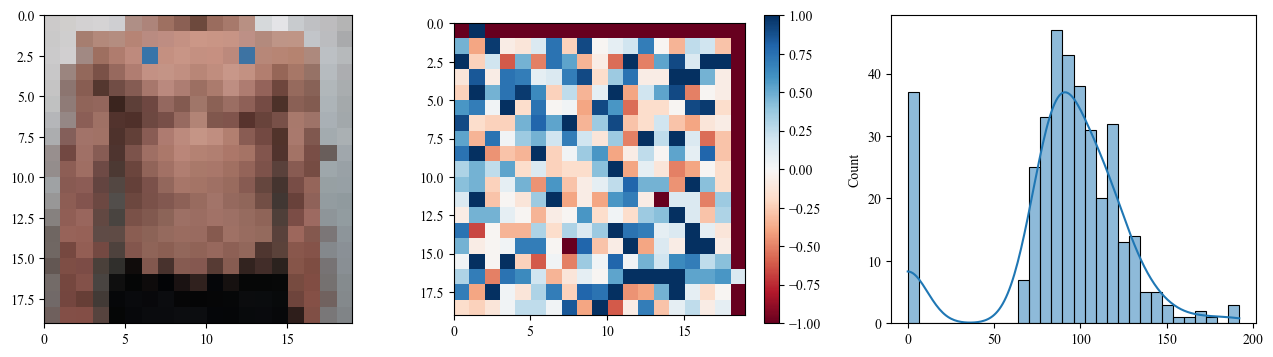

In [167]:
bpm_chrom = fit(red_signals, green_signals, blue_signals, fit_chrom)
score(bpm_chrom, resolution=19)